In [6]:
import cv2 as cv

img = None
#cv.imshow('image', img)

cv.waitKey(0)
cv.destroyAllWindows()


In [36]:
#define all needed functions
import os
import glob
import shutil

def extract_characters_from_image(image): #results in /results
    img = cv.imread(image)
    if img is None:
        print(f"Error: Could not read image {image}")
        return

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #cv.imshow('gray image', gray)

    # Optional: improve contrast
    gray = cv.equalizeHist(gray)

    # Threshold (adaptive) – keep text white, background black
    thresh = cv.adaptiveThreshold(
        gray, 255,
        cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY_INV,
        35, 10
    )
    cv.imshow('thresholded image', thresh)

    # Morphology to clean noise (larger kernel)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3)) #bigger numbers add background blur
    morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=1)  # remove specks
    morph = cv.morphologyEx(morph, cv.MORPH_CLOSE, kernel, iterations=1)  # connect strokes
    cv.imshow('morphological image', morph)

    # Use connected components instead of contours
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(morph, connectivity=8)

    # Visualization
    vis = cv.cvtColor(morph, cv.COLOR_GRAY2BGR)

    os.makedirs("results", exist_ok=True)

    for i in range(1, num_labels):  # skip background
        x, y, w, h, area = stats[i]

        # Filter blobs (remove tiny specks and very large areas)
        if area < 50 or w*h > 0.15*img.shape[0]*img.shape[1]:
            continue

        char_img = morph[y:y+h + 20, x:x+w]
        cv.imwrite(f'results/char_{i}.png', char_img)

        # Draw boxes for visualization
        cv.rectangle(vis, (x, y), (x+w, y+h + 10), (0, 255, 0), 1)

    cv.imshow("characters", vis)

    cv.waitKey(0)
    cv.destroyAllWindows()



def clear_folder(folder_path: str):
    """
    Clears all contents of the given folder but keeps the folder itself.
    If the folder does not exist, it will be created.
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
        return

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)      # delete file or symlink
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # delete folder
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

    print(f"Cleared contents of: {folder_path}")
        
    

In [40]:
extract_characters_from_image('./data/tests/test4.png')

In [38]:
clear_folder('results')  # Clear the results folder

Cleared contents of: results


In [31]:
from PIL import Image
import pytesseract

def recognize_character(image_path: str) -> str:
    """
    Receives an image path containing a single alphanumeric character
    and returns the recognized character.
    """
    img = Image.open(image_path)

    # Restrict OCR to only alphanumeric characters
    config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'

    char = pytesseract.image_to_string(img, config=config)

    return char.strip()  # remove whitespace/newlines

In [32]:
#First Test Successful
result = recognize_character('./data/model-citizen/char_t.png') #letter recognized as t
print(f"Recognized character: {result}") 
result = recognize_character('./data/model-citizen/char_2.png')
print(f"Recognized character: {result}")  #letter recognized as 2
result = recognize_character('./data/model-citizen/char_te.png')
print(f"Recognized character: {result}")  #letter recognized as te
result = recognize_character('./data/model-citizen/char_th.png')
print(f"Recognized character: {result}")  #letter recognized as (none)


Recognized character: t
Recognized character: 2
Recognized character: te
Recognized character: 


In [77]:
def pair_characters_with_tesseract(folder, results_paired):
    for filename in os.listdir(folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):  # only images
            image_path = os.path.join(folder, filename)
            
            
            # recognize character
            char = recognize_character(image_path)
            if not char:  
                char = "UNKNOWN"  # fallback if OCR fails
            
            # create subfolder for this character
            char_folder = os.path.join(results_paired, char)
            os.makedirs(char_folder, exist_ok=True)

            # copy image into the character's folder
            dest_path = os.path.join(char_folder, filename)
            shutil.copy(image_path, dest_path)


    """
    Pairs each character image in the 'results' folder with its recognized character.
    Creates subfolders in 'results_paired' named after each recognized character,
    and copies the corresponding images into these folders.
    """

# folder = './results'  # folder containing character images
# results_paired = './results_paired'  # folder to save paired results
# '''results_paired folder stores directories named after the recognized character,
# each containing the recognized character image.'''



In [78]:
folder = './results'  # folder containing character images
results_paired = './results_paired_Pytesseract'  # folder to save paired results
pair_characters_with_tesseract(folder, results_paired)

In [75]:
#clear_folder('results')  
clear_folder('results_paired_Pytesseract')  # Clear the results_paired folder

Cleared contents of: results_paired_Pytesseract


In [22]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import load_model

In [23]:
#model.save("emnist_char_model.keras")
model = load_model("emnist_char_model.keras")


In [48]:
# model = load_model("emnist_char_model")
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# # Load a sample image and preprocess it
# # Mapping EMNIST labels to characters (62 classes: 0-9, A-Z, a-z)
# # EMNIST ByClass mapping (example)
emnist_labels = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"  #0-10, A-Z, a-z
def predict_char(model, image_path: str, show_image: bool = True):
    """
    Given a trained model and a path to a character image,
    preprocesses the image, optionally shows it, and returns the predicted character.
    Rotates the image 90 degrees before prediction.
    """
    # Load and preprocess image
    img = Image.open(image_path).convert("L")  # grayscale
    img = img.resize((28, 28))                 # resize to 28x28

    # Rotate image 90 degrees counterclockwise
    img = img.rotate(90, expand=True)

    img = np.array(img)

    # Normalize to 0-1
    img_norm = img / 255.0

    # Optionally show the preprocessed image
    if show_image:
        plt.imshow(img_norm, cmap='gray')
        plt.title("Preprocessed Image")
        plt.axis('off')
        plt.show()

    # Add batch and channel dimension: (1, 28, 28, 1)
    img_input = np.expand_dims(img_norm, axis=(0, -1))

    # Predict
    preds = model.predict(img_input)
    class_index = np.argmax(preds)
    predicted_char = emnist_labels[class_index]

    print(f"Predicted character: {predicted_char}")
    return predicted_char

# def predict_char(model, image_path: str, show_image: bool = True):
#     """
#     Given a trained model and a path to a character image,
#     preprocesses the image, optionally shows it, and returns the predicted character.
#     """
#     # Load and preprocess image
#     img = Image.open(image_path).convert("L")  # grayscale
#     img = img.resize((28, 28))                 # resize to 28x28
#     img = np.array(img)

#     # Normalize to 0-1
#     img_norm = img / 255.0

#     # Optionally show the preprocessed image
#     if show_image:
#         plt.imshow(img_norm, cmap='gray')
#         plt.title("Preprocessed Image")
#         plt.axis('off')
#         plt.show()

#     # Add batch and channel dimension: (1, 28, 28, 1)
#     img_input = np.expand_dims(img_norm, axis=(0, -1))

#     # Predict
#     preds = model.predict(img_input)
#     class_index = np.argmax(preds)
#     predicted_char = emnist_labels[class_index]

#     print(f"Predicted character: {predicted_char}")
#     return predicted_char

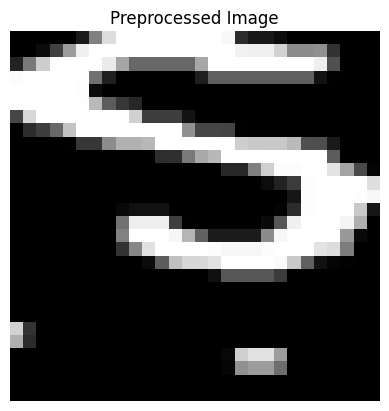

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted character: W


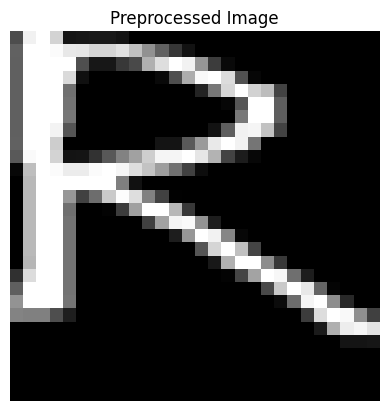

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted character: R


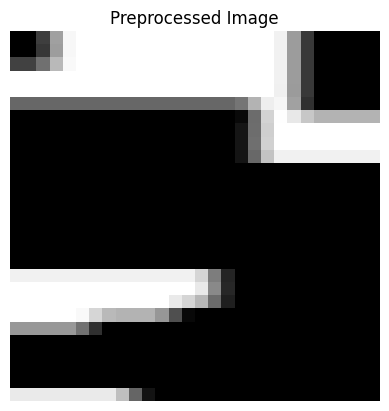

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted character: N


'N'

In [45]:
predict_char(model, './data/model-citizen/char_S.png')  # Example usage
predict_char(model, './data/model-citizen/char_R.png')
predict_char(model, './data/model-citizen/char_NONE.png')

In [61]:
def pair_characters_with_emnist(folder, results_paired):
    clear_folder(results_paired)  # Clear the results_paired folder
    """
    Pairs each character image in the 'folder' with its predicted character using the EMNIST model.
    Creates subfolders in 'results_paired' named after each predicted character,
    and copies the corresponding images into these folders.
    """
    for filename in os.listdir(folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):  # only images
            image_path = os.path.join(folder, filename)

            # Predict character using EMNIST model, do not show image
            predicted_char = predict_char(model, image_path, show_image=False)
            if not predicted_char:
                predicted_char = "UNKNOWN"

            # create subfolder for this character
            char_folder = os.path.join(results_paired, str(predicted_char))
            os.makedirs(char_folder, exist_ok=True)

            # copy image into the character's folder
            dest_path = os.path.join(char_folder, filename)
            shutil.copy(image_path, dest_path)
            

In [62]:
pair_characters_with_emnist("./results", "./results_paired_EMNIST")  # Default paths if not provided

Cleared contents of: ./results_paired_EMNIST
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted character: n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted character: M
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted character: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted character: T
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted character: M
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted character: P
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted character: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted character: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted character: P
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted character: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted character: T
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted character: Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted character: r
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted character: N
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted character: Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Pr

In [49]:
clear_folder('./results_paired_EMNIST')  # Clear the results_paired folder
folder = './results'  # folder containing character images
results_paired = './results_paired_EMNIST'  # folder to save paired results
pair_characters_with_emnist(folder, results_paired)

Cleared contents of: ./results_paired_EMNIST
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted character: n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted character: M
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted character: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted character: T
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted character: P
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted character: M
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted character: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted character: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted character: P
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicted character: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted character: T
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted character: Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted character: r
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted character: N
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted character: Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
P